In [48]:
#!nvcc --version


In [47]:
#!pip install tensorflow-gpu

In [46]:
#from tensorflow.python.client import device_lib 
#print(device_lib.list_local_devices())

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')


Num GPUs Available:  4


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
# import

import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [29]:
base_path = './140K-data/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.,validation_split = 0.01)
batch_size = 48
image_size = (224,224)
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset = 'validation'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset = 'validation'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary',
    subset = 'validation'
)

Found 1000 images belonging to 2 classes.
Found 105 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [31]:
densenet = DenseNet169(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
#model = build_model(densenet)

model = Sequential([
    densenet,
    #layers.Dropout(0.05),
    layers.GlobalAveragePooling2D(),
    
    layers.BatchNormalization(),
    layers.Dropout(0.05),
    layers.Dense(32, activation='sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='sigmoid'),
    layers.Dropout(0.05),
    layers.Dense(512, activation='sigmoid'),
    #layers.Dropout(0.05),
    layers.Dense(1, activation='sigmoid', name = 'Dense_End')
])
    
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [32]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1664)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1664)              6656      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                53280     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [23]:
#print(train_flow)
#train_flow[0:10]


# Model Visualization

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.10/install/bin/python3.8 -m pip install --upgrade pip' command.


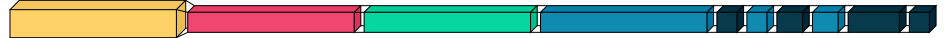

In [33]:
!pip install visualkeras
import visualkeras

#model = ...

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [35]:
train_steps = 1000 //48
valid_steps = 80//48
history = model.fit_generator(
    train_flow,
    epochs=10,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/10
20/20 [==============================] - 23s 1s/step - loss: 0.7124 - accuracy: 0.5000 - val_loss: 1.0036 - val_accuracy: 0.0000e+00
Epoch 2/10
20/20 [==============================] - 23s 1s/step - loss: 0.6966 - accuracy: 0.5137 - val_loss: 0.7468 - val_accuracy: 0.3333
Epoch 3/10
20/20 [==============================] - 23s 1s/step - loss: 0.6924 - accuracy: 0.5515 - val_loss: 0.7551 - val_accuracy: 0.0625
Epoch 4/10
20/20 [==============================] - 23s 1s/step - loss: 0.6890 - accuracy: 0.5630 - val_loss: 0.6757 - val_accuracy: 0.7500
Epoch 5/10
20/20 [==============================] - 23s 1s/step - loss: 0.6815 - accuracy: 0.5830 - val_loss: 1.1361 - val_accuracy: 0.0833
Epoch 6/10
20/20 [==============================] - 23s 1s/step - loss: 0.7132 - accuracy: 0.5126 - val_loss: 0.6325 - val_accuracy: 0.8750
Epoch 7/10
20/20 [==============================] - 23s 1s/step - loss: 0.6927 - accuracy: 0.5284 - val_loss: 0.7248 - val_accuracy: 0.1667
Epoch 8/10
20/20

In [36]:
model.save('densenet.h5')

In [37]:
print(history.history)

{'loss': [0.7123660445213318, 0.6966061592102051, 0.692436695098877, 0.6889755725860596, 0.6815422773361206, 0.7132439017295837, 0.6926712393760681, 0.6871652603149414, 0.6779374480247498, 0.6685216426849365], 'accuracy': [0.5, 0.5136554837226868, 0.5514705777168274, 0.5630252361297607, 0.5829831957817078, 0.5126050710678101, 0.5283613204956055, 0.5588235259056091, 0.5735294222831726, 0.5945377945899963], 'val_loss': [1.0035678148269653, 0.7468073964118958, 0.7550811171531677, 0.6756620407104492, 1.1361169815063477, 0.6325373649597168, 0.7247850298881531, 0.7995687127113342, 1.0333501100540161, 0.7401900291442871], 'val_accuracy': [0.0, 0.3333333432674408, 0.0625, 0.75, 0.0833333358168602, 0.875, 0.1666666716337204, 0.3125, 0.1041666641831398, 0.75]}


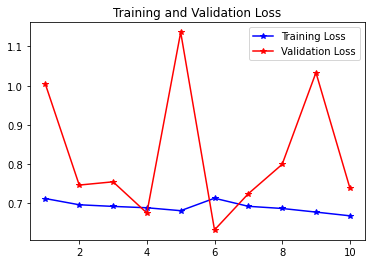

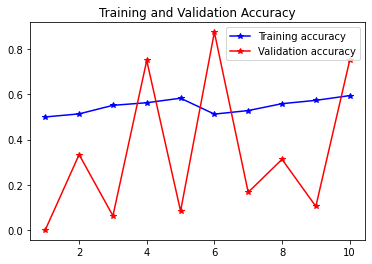

In [38]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, '*-b', label='Training Loss')
    plt.plot(epochs, val_loss, '*-r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, '*-b', label='Training accuracy')
    plt.plot(epochs, val_acc, '*-r', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

# Predict and Evaluation

In [39]:
print(model.metrics_names)
test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split = 0.01)
testpath = './140K-data/real_vs_fake/real-vs-fake/'

eval_generator = test_datagen.flow_from_directory(testpath + 'test/',
                                                  target_size=image_size,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  seed=42,
                                                  class_mode="binary",
                                                  subset = 'validation'
                                                 )
eval_generator.reset()
print(len(eval_generator))
#x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                          # use_multiprocessing = False,verbose = 1,workers=1)
x = model.evaluate(eval_generator)

print('Test loss:' , x[0])
print('Test accuracy:',x[1])
print(model.metrics_names)

['loss', 'accuracy']
Found 200 images belonging to 2 classes.
200
200/200 [==============================] - 8s 38ms/step - loss: 0.6709 - accuracy: 0.5650
Test loss: 0.6709374785423279
Test accuracy: 0.5649999976158142
['loss', 'accuracy']


In [40]:
y_pred = model.predict(eval_generator)
y_test = eval_generator.classes

In [41]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.5079500000000001
AP Score: 0.5089494194832265

              precision    recall  f1-score   support

           0       0.49      0.79      0.61       100
           1       0.46      0.18      0.26       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.43       200
weighted avg       0.48      0.48      0.43       200



## TSNE Graph


In [42]:
#model.get_layer("dense_1").output
#l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]

Found 70 images belonging to 2 classes.
70/70 [==============================] - 3s 37ms/step
(70, 1)
(70, 2)
35
35
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


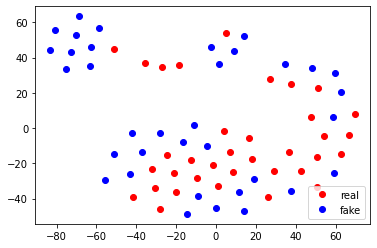

In [43]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('Dense_End').output)

newDataGen = ImageDataGenerator(rescale=1. / 255, validation_split = 0.0035)

tsne_eval_generator = newDataGen.flow_from_directory(base_path+'test/',target_size=image_size,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="binary", subset = 'validation')

    
pred = intermediate_layer_model.predict_generator(tsne_eval_generator,70,verbose=1)
print(pred.shape)
features = TSNE(n_components=2).fit_transform(pred)
print(features.shape)

x1,x2,y1,y2 = [],[],[],[]
cls = tsne_eval_generator.classes
sumA = 0 
sumB = 0
for i in cls:
    if i ==0:
        sumA+=1
    else:
        sumB+=1
        
print(sumA)
print(sumB)
print(cls)
for i in range(len(features)):
    if cls[i] == 0: 
        x1.append(features[i, 0])
        y1.append(features[i, 1])    
    else:
        x2.append(features[i, 0])
        y2.append(features[i, 1])

plt.figure()
plt.plot(x1, y1, 'ro', label="real")
plt.plot(x2, y2, 'bo', label="fake")
plt.legend(loc='lower right')